# Airlines Ticket Forecasting 1949-1960



In [20]:
import math
import numpy as np
import pandas as pd

# Date & Time
import datetime
import matplotlib.dates as mdates

# TSA from Statsmodels
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

#Ploting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Reading The Data

In [21]:
air_data = pd.read_csv("data/AirPassengers.csv", header = 0, index_col=0)
air_data.head(13)

,time,AirPassengers
1,1949.000000,112
2,1949.083333,118
3,1949.166667,132
4,1949.250000,129
5,1949.333333,121
6,1949.416667,135
7,1949.500000,148
8,1949.583333,148
9,1949.666667,136
10,1949.750000,119


### Data Preprocessing:
the formating of the need to be transformed into dates

In [22]:
n = len(air_data.index)
temp_time = pd.DataFrame({'year': [int(math.floor(air_data['time'][i])) for i in range (1, n+1)],
                          'month': [int(round((air_data['time'][i]-int(math.floor(air_data['time'][i])))*12, 0))+1 
                                    for i in range (1, n+1)],
                          'day': [1]*n}, index=air_data.index)

air_data['time'] = pd.to_datetime(temp_time)
air_data.head(13)

,time,AirPassengers
1,1949-01-01,112
2,1949-02-01,118
3,1949-03-01,132
4,1949-04-01,129
5,1949-05-01,121
6,1949-06-01,135
7,1949-07-01,148
8,1949-08-01,148
9,1949-09-01,136
10,1949-10-01,119


## Exploring the Time Series:
To determine its componenets: Error, Trend and Seasonality (ETS)

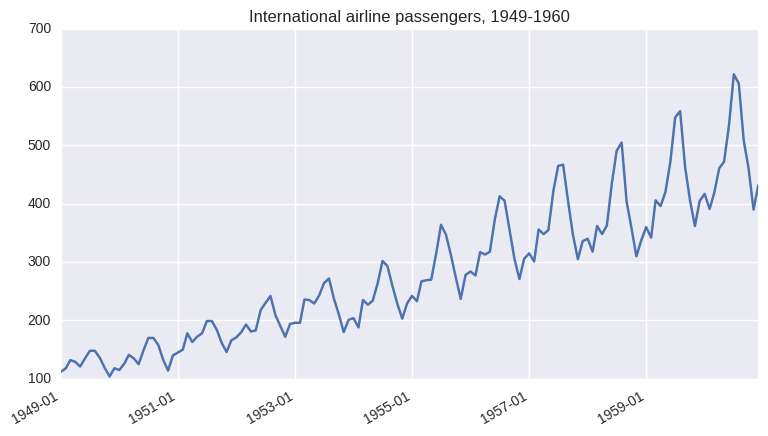

In [23]:
x_axis = pd.DataFrame([mdates.date2num(air_data['time'][i]) for i in range(1,n+1)])
# [mdates.date2num(air_data['time'][i]) for i in range(1,n)]

fig, ax = plt.subplots(figsize=(9,5));
ax.set_title('International airline passengers, 1949-1960');
sns.tsplot(data=air_data['AirPassengers'], time=x_axis, ax=ax)
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
fig.autofmt_xdate()
plt.show()

## ETS Approch:
1- Check the components of the series (Trend and Seasonality).<br>
2- Stationarize the series.<br>
3- Apply the appropriate ETS model.<br>

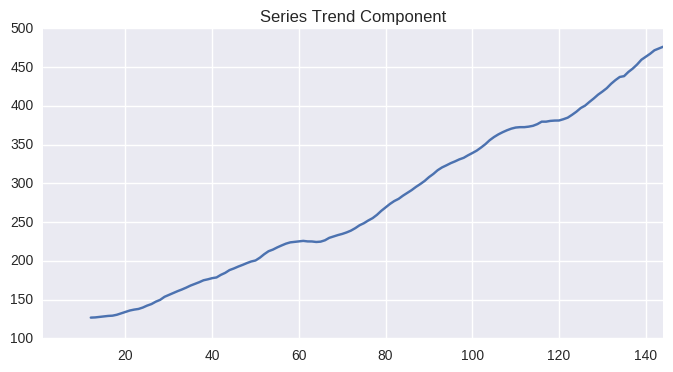

In [30]:
moving_avg = air_data['AirPassengers'].rolling(window=12,center=False).mean()

fig, ax = plt.subplots(figsize=(8,4));
ax.set_title('Series Trend Component');
moving_avg.plot()
plt.show()

From the 2 figures above, one can conclude the the series has an additive trend with a multiplicative seasonality. Hence, Seasonal Holts winter method can be utilized.

## Box-Jenkins Approach:
#### 1- Stationarize the Series:
* There are several diffrenceing methods can be used to stationarize the series such as: Deflation by CPI, Logarithmic Function, Difference, Seasonal Difference and Seasonal Adjustment.

* Usually Dickey-Fuller test is used to assess the stationarity of the series and compare the previous methods (the test statistic must be greater than the critical value).

* However I used the first and second Seasonal Difference and choosed the one with the minimum variance.

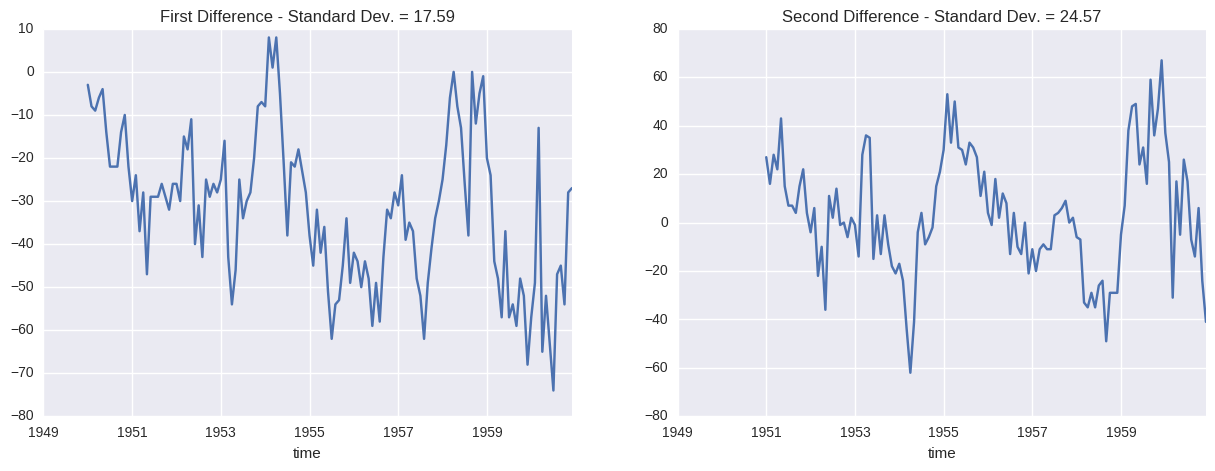

In [16]:
air_data['firstDiff'] = air_data['AirPassengers'].shift(12) - air_data['AirPassengers']
air_data['secondDiff'] = air_data['firstDiff'].shift(12) - air_data['firstDiff']

fig = plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.title("First Difference - Standard Dev. = {}".format(round(np.std(air_data['firstDiff']),2)));
pd.Series(air_data['firstDiff']).plot()
plt.subplot(122)
plt.title("Second Difference - Standard Dev. = {}".format(round(np.std(air_data['secondDiff']),2)));
pd.Series(air_data['secondDiff']).plot()
plt.show()

### Exploring the ACF and PACF:
To determine the SARIMA components

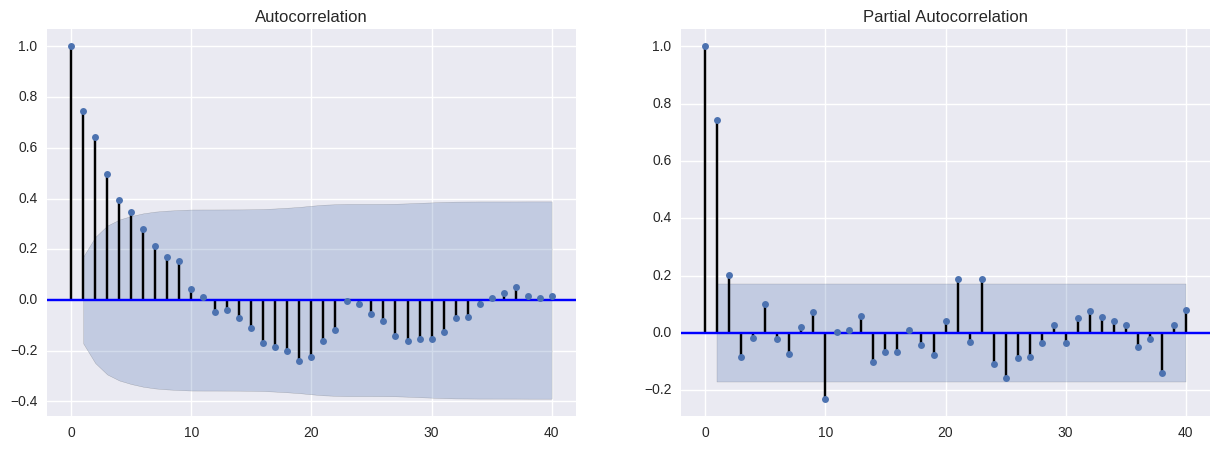

In [12]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
fig = smt.graphics.plot_acf(air_data['firstDiff'].iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(122)
fig = smt.graphics.plot_pacf(air_data['firstDiff'].iloc[13:], lags=40, ax=ax2)

In [13]:
results.plot_diagnostics(figsize=(16, 12));

NameError: name 'results' is not defined

# Building & Train the SARIMA Model
Note That, I kept the last cycle out of the trainnig process for the testing phase

In [14]:
air_data = air_data.set_index('time')
mod = sm.tsa.statespace.SARIMAX(air_data['AirPassengers'][1:132], order=(1,0,0), seasonal_order=(1,1,0,12))
results = mod.fit()
print results.summary()

                                 Statespace Model Results                                 
Dep. Variable:                      AirPassengers   No. Observations:                  131
Model:             SARIMAX(1, 0, 0)x(1, 1, 0, 12)   Log Likelihood                -451.311
Date:                            Thu, 06 Jul 2017   AIC                            908.622
Time:                                    22:16:19   BIC                            917.248
Sample:                                02-01-1949   HQIC                           912.127
                                     - 12-01-1959                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9643      0.025     38.810      0.000       0.916       1.013
ar.S.L12      -0.1206      0.089   

# Prediction

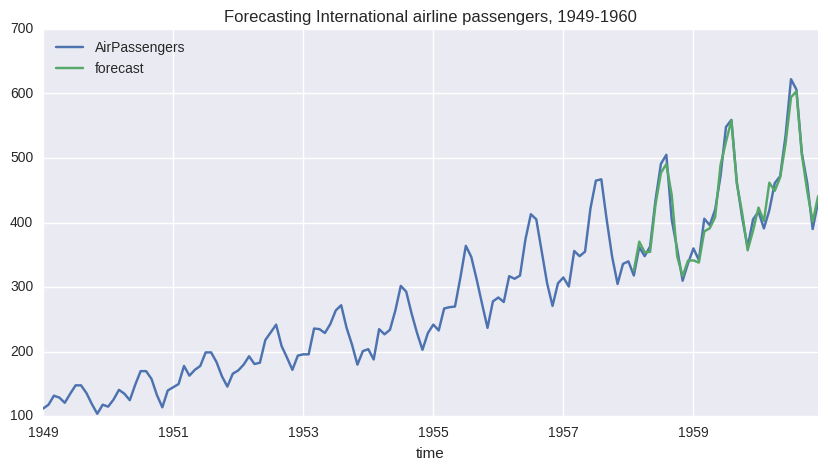

In [15]:
pred_begin = air_data.index[-35]
pred_end = air_data.index[-1]
air_data['forecast'] = results.get_prediction(start=pred_begin.strftime('%Y-%m-%d'),
                                              end=pred_end.strftime('%Y-%m-%d')).predicted_mean


air_data[['AirPassengers', 'forecast']].plot(figsize=(10, 5)).set_title(
          'Forecasting International airline passengers, 1949-1960');